In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install hazm

In [ ]:
from __future__ import unicode_literals
import pandas as pd
import numpy as np
import sklearn
import hazm
from hazm.utils import stopwords_list

Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/My Drive/vehicles.csv" "vehicles.csv"

In [ ]:
data = pd.read_csv("vehicles.csv")
print(data.columns)
print(data.shape)
data = data.dropna(axis=0, how='any')
print(data.dtypes)
# print(data['brand'].isnull().sum(axis = 0))
# print(data['category'].isnull().sum(axis = 0))
# print(data['created_at'].isnull().sum(axis = 0))
# print(data['description'].isnull().sum(axis = 0))
# print(data['image_count'].isnull().sum(axis = 0))
# print(data['mileage'].isnull().sum(axis = 0))
# print(data['price'].isnull().sum(axis = 0))
# print(data['title'].isnull().sum(axis = 0))
# print(data['year'].isnull().sum(axis = 0))

data['brand'] = data['brand'].astype('category').cat.codes
data['category'] = data['category'].astype('category').cat.codes
data['year'] = data['year'].astype('category').cat.codes
data['created_at'] = data['created_at'].map(lambda x: x[:-5])
data['created_at'] = data['created_at'].astype('category').cat.codes
des = data['description'].values
title =  data['title'].values
# des
# data['brand'].unique()
# print(data['created_at'].unique())

Index(['brand', 'category', 'created_at', 'description', 'image_count',
       'mileage', 'price', 'title', 'year'],
      dtype='object')
(130443, 9)
brand           object
category        object
created_at      object
description     object
image_count      int64
mileage        float64
price            int64
title           object
year            object
dtype: object


Preprocessing

In [ ]:
from hazm import Normalizer
from hazm import *
def strip_punc(s):
  punctuations = '''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~،؛,»«<>؟!1234567890'''
  return ''.join(c for c in s if c not in punctuations)

def preprocessing(data):
  arr = []
  for i in range(len(data)):
    res1 = strip_punc(data[i])
    normalizer = Normalizer()
    res2 = normalizer.normalize(res1)
    stemmer = Stemmer()
    res3 = stemmer.stem(res2)
    arr.append(res3)
  return arr

data_description_arr = preprocessing(des)
data_title_arr = preprocessing(title)
# data_description_arr

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.62874837] [0.0010547] [0.01304546] [0.21899653] [0.49807196]
[0.62874837 0.0010547  0.00555215 0.01304546 0.21899653 0.49807196]


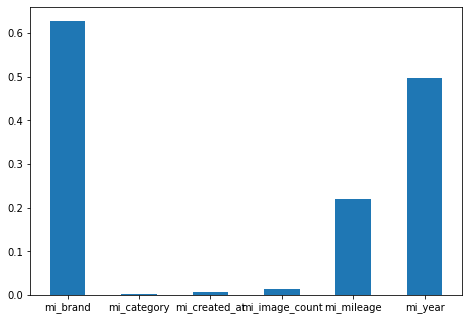

In [ ]:
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, mutual_info_regression
import matplotlib.pyplot as plt

mi_brand = mutual_info_classif(np.array(data['brand']).reshape(-1,1), np.array(data['price']).reshape(-1,1))
mi_category = mutual_info_classif(np.array(data['category']).reshape(-1,1), np.array(data['price']).reshape(-1,1))
mi_createdat = mutual_info_classif(np.array(data['created_at']).reshape(-1,1), np.array(data['price']).reshape(-1,1))
# mi_description = mutual_info_classif(np.array(data['description']).reshape(-1,1), np.array(data['price']).reshape(-1,1))
mi_image_count = mutual_info_classif(np.array(data['image_count']).reshape(-1,1), np.array(data['price']).reshape(-1,1))
mi_mileage = mutual_info_classif(np.array(data['mileage']).reshape(-1,1), np.array(data['price']).reshape(-1,1))
# mi_title = mutual_info_classif(np.array(data['title']).reshape(-1,1), np.array(data['price']).reshape(-1,1))
mi_year = mutual_info_classif(np.array(data['year']).reshape(-1,1), np.array(data['price']).reshape(-1,1))
print(mi_brand,mi_category,mi_image_count,mi_mileage,mi_year)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['mi_brand','mi_category','mi_created_at','mi_image_count','mi_mileage','mi_year']
y = [float(mi_brand),float(mi_category),float(mi_createdat),float(mi_image_count),float(mi_mileage),float(mi_year)]
y = np.array(y)
print(y)
ax.bar(x,y, width=0.5)
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer1 = CountVectorizer(min_df=0.1,max_df=0.9,ngram_range=(1,3))
desc_tokens = vectorizer1.fit_transform(data_description_arr)

vectorizer2 = CountVectorizer(min_df=0.1,max_df=0.9,ngram_range=(1,3))
title_tokens = vectorizer2.fit_transform(data_title_arr)

desc_df = pd.DataFrame(desc_tokens.toarray(),columns=vectorizer1.get_feature_names())
title_df = pd.DataFrame(title_tokens.toarray(),columns=vectorizer2.get_feature_names())

data = pd.concat([data,desc_df,title_df])
data = data.fillna(0)
data

,brand,category,created_at,description,image_count,mileage,price,title,year,از,با,بدون,بدون رنگ,برج,به,بیمه,بیمه تا,تا,تا برج,تخفیف,تخفیف بیمه,تمیز,رنگ,سال,سال تخفیف,سالم,عقب,فقط,فنی,لاستیک,ماشین,مدل,نو,یک,پراید,پژو
1,10.0,0.0,6.0,دوگانه ال پی جی بیمه با تخفیف دارد \nتودوزی نو...,3.0,180000.0,-1.0,پاترول شش سیلندر چهار درب,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23.0,0.0,6.0,پژو 2000فنی تازه تعمیر بدنه بدون خطو خش تخیف ب...,0.0,290000.0,8500000.0,پژو مدل 81 مشکی,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.0,0.0,6.0,سلام.\nماشین کاملا سالم همه چی فابریک متور زد ...,3.0,175000.0,19500000.0,پاترول 2در,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.0,0.0,4.0,سمند ال ایکس بدون رنگ تمامی سرویس ها انجام شده...,4.0,80000.0,23900000.0,سمند دوگانه کارخانه,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,23.0,0.0,4.0,بیمه یکسال ده سال تخفیف دور رنگ شاسی پلمپ سالم,3.0,125000.0,8500000.0,پژو405 مدل84,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120446,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
120447,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120448,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
120449,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Create model

In [ ]:
from sklearn.model_selection import train_test_split

y = data['price']
X = data.drop(['price','description','title','category'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = False)

Decision Tree

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
dtclassifier = DecisionTreeClassifier()
dtclassifier.fit(X_train, y_train)
y_pred = dtclassifier.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
mean_squared_error(y_test,y_pred,squared=False)
print(dtclassifier.tree_.max_depth)

40


Rmse_train Score: 18925575.230948877
Rmse_test Score: 18689445.172588147
Rmse_train Score: 18925575.231198102
Rmse_test Score: 18689445.172735333
Rmse_train Score: 18925575.231198102
Rmse_test Score: 18689445.172735333
Rmse_train Score: 18925518.203588165
Rmse_test Score: 18689445.172735333
Rmse_train Score: 18925071.621186018
Rmse_test Score: 18689142.90214439
Rmse_train Score: 18924555.27751507
Rmse_test Score: 18689323.754235856
Rmse_train Score: 18916640.902356394
Rmse_test Score: 18683098.227204297
Rmse_train Score: 18742645.969891306
Rmse_test Score: 18499763.80981665
Rmse_train Score: 18632075.558208097
Rmse_test Score: 18394241.41902767
Rmse_train Score: 18217037.418860562
Rmse_test Score: 18019535.114638124
Rmse_train Score: 17802509.46614586
Rmse_test Score: 17777766.36099964
Rmse_train Score: 17517793.482878085
Rmse_test Score: 17529326.693164513
Rmse_train Score: 16694368.134185245
Rmse_test Score: 16993258.59432894
Rmse_train Score: 16130727.591795309
Rmse_test Score: 1665

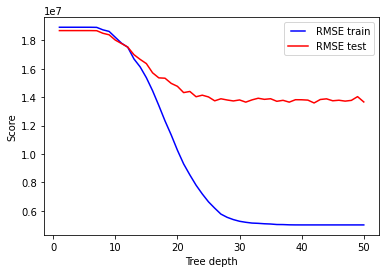

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from matplotlib.legend_handler import HandlerLine2D

Rmse_test = []
Rmse_train = []
max_depths = np.linspace(1, 50, 50, endpoint=True)

for max_depth in max_depths:
  dtclassifier = DecisionTreeClassifier(max_depth=max_depth,min_samples_split=2)
  dtclassifier.fit(X_train, y_train)
  y_pred = dtclassifier.predict(X_test)
  y_pred_train = dtclassifier.predict(X_train)
  mse = mean_squared_error(y_test,y_pred)
  rmse_test = mean_squared_error(y_test,y_pred,squared=False)
  rmse_train = mean_squared_error(y_train,y_pred_train,squared=False)

  Rmse_test.append(rmse_test)
  Rmse_train.append(rmse_train)
  print('Rmse_train Score:', rmse_train)
  print('Rmse_test Score:',rmse_test)


line1, = plt.plot(max_depths, Rmse_train, 'b', label='RMSE train')
line2, = plt.plot(max_depths, Rmse_test, 'r', label='RMSE test')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Score')
plt.xlabel('Tree depth')
plt.show()

RMSE Score: 13717802.385351252
MSE Score: 188178102283548.47
RMSE Score: 13636114.743628142
MSE Score: 185943625301392.8
RMSE Score: 13729999.724466413
MSE Score: 188512892433847.78
RMSE Score: 13893448.131079948
MSE Score: 193027900971008.88
RMSE Score: 14517319.091099055
MSE Score: 210752553592789.1
RMSE Score: 14803905.404264115
MSE Score: 219155615218400.25
RMSE Score: 14940018.562774656
MSE Score: 223204154656051.28
RMSE Score: 15158423.671586627
MSE Score: 229777808207317.8
RMSE Score: 15280442.897727318
MSE Score: 233491935150705.22
RMSE Score: 15638999.356156856
MSE Score: 244578300861874.56
RMSE Score: 15804006.817624241
MSE Score: 249766631491513.47
RMSE Score: 15925402.636160584
MSE Score: 253618449123830.5


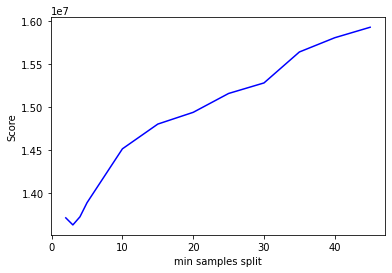

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

Rmse = []
Mse = []
min_samples_splits = [2,3,4,5,10,15,20,25,30,35,40,45]

for min_samples_split in min_samples_splits:
  dtclassifier = DecisionTreeClassifier(max_depth=42,min_samples_split=min_samples_split)
  dtclassifier.fit(X_train, y_train)
  y_pred = dtclassifier.predict(X_test)
  mse = mean_squared_error(y_test,y_pred)
  rmse = mean_squared_error(y_test,y_pred,squared=False)
  Rmse.append(rmse)
  Mse.append(mse)
  print('RMSE Score:', rmse)
  print('MSE Score:', mse)
plt.plot(min_samples_splits, Rmse, 'b', label='RMSE')
plt.ylabel('Score')
plt.xlabel('min samples split')
plt.show()

Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
coef = lr.coef_
intercept = lr.intercept_
y_pred = lr.predict(X_test)
lr.score(X_train, y_train)
mse = mean_squared_error(y_test,y_pred)
rmse = mean_squared_error(y_test,y_pred,squared=False)
rmse

13860931.545627901

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
Rmse_test = []
Rmse_train = []
max_depths = [2,5,10]

for max_depth in max_depths:

  clf = RandomForestClassifier(max_depth=max_depth, random_state=0)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  y_pred_train = clf.predict(X_train)
  mse = mean_squared_error(y_test,y_pred)
  rmse_test = mean_squared_error(y_test,y_pred,squared=False)
  rmse_train = mean_squared_error(y_train,y_pred_train,squared=False)
  Rmse_test.append(rmse_test)
  Rmse_train.append(rmse_train)

  print('Rmse_train Score:', rmse_train)
  print('Rmse_test Score:',rmse_test)


line1, = plt.plot(max_depths, Rmse_train, 'b', label='RMSE train')
line2, = plt.plot(max_depths, Rmse_test, 'r', label='RMSE test')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Score')
plt.xlabel('Tree depth')
plt.show()

KeyboardInterrupt: ignored

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
rmse = mean_squared_error(y_test,y_pred,squared=False)
rmse

17271214.410133738